# Multilabel Classification

In multi-label classification, each sample can have multiple labels associated with it, as opposed to the traditional single-label classification where each sample can have only one label associated with it. <br/>

This means that the output of a multi-label classifier is an array of probabilities, one for each label, indicating the probability of the input sample belonging to each label.

## Setting Up

In [1]:
!nvidia-smi

Sun Jun 30 17:50:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


The repository for squad contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/squad.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/StackExchange-Scifi-Tags-Classifier/notebooks/bert-base-uncased/

/content/drive/MyDrive/StackExchange-Scifi-Tags-Classifier/notebooks/bert-base-uncased


## Data

In [7]:
df = pd.read_csv("../../data/question_details.csv")
df.head()

,title,url,description,tags
0,Would the One Ring even work for anyone but Sauron?,https://scifi.stackexchange.com/questions/48180/would-the-one-ring-even-work-for-anyone-but-sauron,"The temptation of the One Ring, we quickly learn, is always tied up with power: each character's fantasies of possessing it seem to be about what they would do with great power. Even Sam, as I recall, imagines the power to create great huge sweeping gardens. Boromir wants the power to save Gondor, etc.\nBut does the One Ring actually convey power to anyone but Sauron? It actually seems to diminish its bearers: Bilbo feels ""thin"" and ""stretched"", Sméagol becomes the wretched Gollum, Frodo is never quite the same even after it is destroyed. None of them seem more ""powerful,"" even in the abst...","['the-lord-of-the-rings', 'tolkiens-legendarium', 'the-one-ring']"
1,Could I fake death to stop being Force-choked?,https://scifi.stackexchange.com/questions/102822/could-i-fake-death-to-stop-being-force-choked,"I work for a large government organization. My boss is a total jerk who abuses those working under him. I've tried contacting HR before but they won't do anything about him.\nAnyways, I screwed up again. My jerk boss is going to be super pissed.\nI came out of hyperspace too close to some stupid planet and the rebels were able to detect us. It's not a big deal really but he'll make a big thing about it like he always does when something isn't his fault. If it were his f- up, he would say something like 'I meant to do that' or 'It went exactly as I had foreseen it' — yeah right.\nI'm going ...","['star-wars', 'the-force', 'the-empire-strikes-back']"
2,Who or what was Tom Bombadil?,https://scifi.stackexchange.com/questions/1586/who-or-what-was-tom-bombadil,"The most iconic of Middle-earth questions:\nWho or what was Tom Bombadil?\nWas he an elf? Was he akin to Gandalf, and one of the wizardly stock? Was he something… else?\n","['the-lord-of-the-rings', 'tolkiens-legendarium', 'tom-bombadil']"
3,Why don&#39;t Muggle-born wizards use Muggle technology to fight Death Eaters?,https://scifi.stackexchange.com/questions/2611/why-dont-muggle-born-wizards-use-muggle-technology-to-fight-death-eaters,"We know that wizards in the Harry Potter universe are subject to regular physical harm (e.g. witness injuries from being hit by Bludgers or just colliding with things when playing Quidditch).\nTherefore, it's almost a certainty that an average wizard would be vulnerable to, say, a bunch of bullets. \nThere may likely be spell(s) to protect from projectiles - witness Dumbledore's shield deployed when Voldemort sent a bunch of glass at him during the Duel in the Ministry Atrium at the end of Harry Potter and the Order of the Phoenix (according to Wikia, possibly an unusually powerful Protego...","['harry-potter', 'technology']"
4,Story where the number 3 is the monster?,https://scifi.stackexchange.com/questions/2937/story-where-the-number-3-is-the-monster,"I remember as a child (in the nineties) reading a story where the narrator was a little boy and how he was scared only twice a day – when the clock read 3:33. The 3's would be powerful enough (there were three of them at 3:33) to leave the clock in the boy's room for one minute and do what they want. They terrified the boy for that one minute they were free. \nI don't think it was R.L. Stine, but I cannot remember the author.\nUpdate: It definitely wasn't R.L Stine, but the story was in a similar style.\nI know it was only a 15-20 page story, so maybe it was in a short story collection?\n","['story-identification', 'short-stories']"


In [8]:
df.shape

(30000, 4)

In [9]:
df = df.dropna().reset_index(drop=True)
df.shape

(30000, 4)

In [10]:
tags_list = df.tags.to_list()
tag_count = {}
for tags in tags_list:
  tag_list = eval(tags)
  for tag in tag_list:
    if tag in tag_count.keys():
      tag_count[tag] += 1
    else:
      tag_count[tag] = 1
print(f"Number of Tags: {len(tag_count)}")
print(tag_count)

Number of Tags: 2095
{'the-lord-of-the-rings': 1390, 'tolkiens-legendarium': 1904, 'the-one-ring': 113, 'star-wars': 3189, 'the-force': 158, 'the-empire-strikes-back': 117, 'tom-bombadil': 18, 'harry-potter': 3454, 'technology': 170, 'story-identification': 8613, 'short-stories': 2763, 'time-travel': 566, 'groundhog-day': 5, 'suggested-order': 137, 'millennium-falcon': 45, 'back-to-the-future': 104, 'back-to-the-future-ii': 22, 'prediction': 11, 'stormtroopers': 28, 'behind-the-scenes': 210, 'the-chronicles-of-narnia': 54, 'cs-lewis': 27, 'xkcd': 9, 'j-r-r-tolkien': 78, 'dc': 900, 'character-identification': 251, 'justice-league': 21, 'merchandise': 5, 'hogwarts': 224, 'et-the-extra-terrestrial': 6, 'shared-universe': 5, 'yoda': 48, 'a-new-hope': 240, 'douglas-adams': 21, 'the-hitchhikers-guide-to-the-galaxy': 67, 'physics': 48, 'batman': 297, 'the-matrix': 264, 'gandalf': 118, 'isaac-asimov': 127, 'foundation': 36, 'horcrux': 130, 'magical-theory': 100, 'star-trek': 2698, 'star-trek-t

In [11]:
threshold = int(len(df) * 0.002)
rare_tags = [key for key, value in tag_count.items() if value < threshold]
len(rare_tags), rare_tags[:5]

(1935,
 ['tom-bombadil',
  'groundhog-day',
  'millennium-falcon',
  'back-to-the-future-ii',
  'prediction'])

In [12]:
tags_list = df.tags.to_list()
revised_tag_list = []
indices_to_drop = []

for idx, tags in enumerate(tags_list):
  tag_list = eval(tags)
  revised_tags = []

  for tag in tag_list:
    if tag not in rare_tags:
      revised_tags.append(tag)

  if len(revised_tags) == 0:
    indices_to_drop.append(idx)
  else:
    revised_tag_list.append(revised_tags)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(27493, 4)

In [13]:
df['revised_tags'] = revised_tag_list

In [14]:
df.tail()

,title,url,description,tags,revised_tags
27488,Did the Third Doctor ever salute the Brigadier?,https://scifi.stackexchange.com/questions/79188/did-the-third-doctor-ever-salute-the-brigadier,"In the finale of Series 8, Brigadier Alistair Lethbridge-Stewart's daughter Kate mentions that it had always been her father's wish that the Doctor would return his salute. Towards the end of the episode,\n\na Cyberman, presumably reanimated from the Brigadier's corpse, receives said salute from the twelfth Doctor.\n\nThe modern Doctor's disdain for salutes is well known. What surprises me, however, is that the third doctor, who had the most extensive relationship with the Brigadier, never returned a salute. While the Doctor was always disdainful of military customs, he was always polite a...",['doctor-who'],[doctor-who]
27489,"Three children get trapped in a painting, inside a maze in a building",https://scifi.stackexchange.com/questions/73430/three-children-get-trapped-in-a-painting-inside-a-maze-in-a-building,"There are three children. They are in some sort of building where there is a painting. There is some sort of maze in the building and one of the children walks through the maze, chanting a particular word. The other two children soon realise that he is missing and imitate what he did before he went missing. The two children find themselves in the painting and they have to find their friend who entered the painting earlier than them. All the people they meet in the painting are unable to move or talk, with a few exceptions. They soon manage to escape from the painting. \n",['story-identification'],[story-identification]
27490,Movie with humans in a floating cryopod where one believes an alien is his mother,https://scifi.stackexchange.com/questions/71910/movie-with-humans-in-a-floating-cryopod-where-one-believes-an-alien-is-his-mothe,"I remember seeing this sci-fi movie in video stores on VHS but don't know the name. I'm guessing its close to late 70s but more likely an 80s movie. It's in color and I remember the graphics as decent. It's been some time so I'll give what I remember. \nThis is a movie that takes place in space.\nThere is a human (or at least appears human) male who seems to float around in a pod with a glass top. It looks like the cryo units in Alien but floats around.\nHe seems to believe an alien or creature is his mother, who tells him the humans who arrive will kill him.\nThe movie ends with him and a...","['story-identification', 'movie']","[story-identification, movie]"
27491,Looking for 80s/90s YA Horror Story Compilation,https://scifi.stackexchange.com/questions/71469/looking-for-80s-90s-ya-horror-story-compilation,"I have been trying to find this collection for a while now; this is the first forum i've asked in. \nIt was probably a short book, with stories in the style of Christopher Pike and R.L. Stine. I only remember two of the stories. \n1.) A girl goes out with her parents--camping or shopping or something--and meets a strange girl around her age who has a t-shirt with two lips on it. She becomes friends with the girl and stuff happens (sorry, i don't remember!), and in the end, the girl has somehow taken her place in her home, and she looks down at herself and sees she is wearing the t-shirt wi...","['story-identification', 'young-adult', 'horror']","[story-identification, young-adult, horror]"
27492,Why didn&#39;t the Joker follow through with his plan at the dinner party?,https://scifi.stackexchange.com/questions/71047/why-didnt-the-joker-follow-through-with-his-plan-at-the-dinner-party,"I just finished reading the Batman arc Death of the Family, and I loved every part of it, but I didn't understand one thing. In the climactic scene toward the end of the story, we find out that...\n\n...the Joker has kidnapped the rest of the Bat-Family, restrained them, and cut off their faces so he could reveal them on silver platters at his ""dinner party.""\n\nIt's a suitably terrifying moment, especially given Jo

In [15]:
revised_tags_list = df.revised_tags.to_list()
revised_tag_count = {}
for tags in revised_tags_list:
  tag_list = tags
  for tag in tag_list:
    if tag in revised_tag_count.keys():
      revised_tag_count[tag] += 1
    else:
      revised_tag_count[tag] = 1
print(f"Number of Tags: {len(revised_tag_count)}")
print(revised_tag_count)

Number of Tags: 160
{'the-lord-of-the-rings': 1390, 'tolkiens-legendarium': 1904, 'the-one-ring': 113, 'star-wars': 3189, 'the-force': 158, 'the-empire-strikes-back': 117, 'harry-potter': 3454, 'technology': 170, 'story-identification': 8613, 'short-stories': 2763, 'time-travel': 566, 'suggested-order': 137, 'back-to-the-future': 104, 'behind-the-scenes': 210, 'j-r-r-tolkien': 78, 'dc': 900, 'character-identification': 251, 'hogwarts': 224, 'a-new-hope': 240, 'the-hitchhikers-guide-to-the-galaxy': 67, 'batman': 297, 'the-matrix': 264, 'gandalf': 118, 'isaac-asimov': 127, 'horcrux': 130, 'magical-theory': 100, 'star-trek': 2698, 'star-trek-tng': 868, 'the-force-awakens': 334, 'uss-enterprise': 61, 'star-wars-legends': 343, 'spaceship': 288, 'marvel': 1884, 'marvel-cinematic-universe': 1117, 'sauron': 111, 'religion': 85, 'comics': 498, 'sith': 136, 'darth-vader': 169, 'return-of-the-jedi': 128, 'revenge-of-the-sith': 124, 'albus-dumbledore': 148, 'severus-snape': 109, 'luke-skywalker': 

In [16]:
encode_tag_types = { key: idx for idx, (key, value) in enumerate(revised_tag_count.items())}
with open("../../deployment/tag_types_encoded.json", "w") as fp:
  json.dump(encode_tag_types, fp)

In [17]:
# We need this because for multilabel classification all tags have possibility to be present in the predictions
categorical_tag_list = []
revised_tags_list = df.revised_tags.to_list()

for revised_tags in revised_tags_list:
  categorical_list = [0] * len(encode_tag_types)
  for tag in revised_tags:
    tag_type_index = encode_tag_types[tag]
    categorical_list[tag_type_index] = 1
  categorical_tag_list.append(categorical_list)

categorical_tag_list[3][:23]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
df['tag_cat_list'] = categorical_tag_list
df.head()

,title,url,description,tags,revised_tags,tag_cat_list
0,Would the One Ring even work for anyone but Sauron?,https://scifi.stackexchange.com/questions/48180/would-the-one-ring-even-work-for-anyone-but-sauron,"The temptation of the One Ring, we quickly learn, is always tied up with power: each character's fantasies of possessing it seem to be about what they would do with great power. Even Sam, as I recall, imagines the power to create great huge sweeping gardens. Boromir wants the power to save Gondor, etc.\nBut does the One Ring actually convey power to anyone but Sauron? It actually seems to diminish its bearers: Bilbo feels ""thin"" and ""stretched"", Sméagol becomes the wretched Gollum, Frodo is never quite the same even after it is destroyed. None of them seem more ""powerful,"" even in the abst...","['the-lord-of-the-rings', 'tolkiens-legendarium', 'the-one-ring']","[the-lord-of-the-rings, tolkiens-legendarium, the-one-ring]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,Could I fake death to stop being Force-choked?,https://scifi.stackexchange.com/questions/102822/could-i-fake-death-to-stop-being-force-choked,"I work for a large government organization. My boss is a total jerk who abuses those working under him. I've tried contacting HR before but they won't do anything about him.\nAnyways, I screwed up again. My jerk boss is going to be super pissed.\nI came out of hyperspace too close to some stupid planet and the rebels were able to detect us. It's not a big deal really but he'll make a big thing about it like he always does when something isn't his fault. If it were his f- up, he would say something like 'I meant to do that' or 'It went exactly as I had foreseen it' — yeah right.\nI'm going ...","['star-wars', 'the-force', 'the-empire-strikes-back']","[star-wars, the-force, the-empire-strikes-back]","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Who or what was Tom Bombadil?,https://scifi.stackexchange.com/questions/1586/who-or-what-was-tom-bombadil,"The most iconic of Middle-earth questions:\nWho or what was Tom Bombadil?\nWas he an elf? Was he akin to Gandalf, and one of the wizardly stock? Was he something… else?\n","['the-lord-of-the-rings', 'tolkiens-legendarium', 'tom-bombadil']","[the-lord-of-the-rings, tolkiens-legendarium]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,Why don&#39;t Muggle-born wizards use Muggle technology to fight Death Eaters?,https://scifi.stackexchange.com/questions/2611/why-dont-muggle-born-wizards-use-muggle-technology-to-fight-death-eaters,"We know that wizards in the Harry Potter universe are subject to regular physical harm (e.g. witness injuries from being hit by Bludgers or just colliding with things when playing Quidditch).\nTherefore, it's almost a certainty that an average wizard would be vulnerable to, say, a bunch of bullets. \nThere may likely be spell(s) to protect from projectiles - witness Dumbledore's shield deployed when Voldemort sent a bunch of glass at him during the Duel in the Ministry Atrium at the end of Harry Potter and the Order of the Phoenix (according to Wikia, possibly an unusually powerful Protego...","['harry-potter', 'technology']","[harry-potter, technology]","[0, 0, 0, 0, 0, 

## Dataloaders and Modeling

In [19]:
labels = list(encode_tag_types.keys())

In [20]:
model_name = "bert-base-uncased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('tag_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [22]:
dls = dblock.dataloaders(df, bs=16)
torch.save(dls, f"../../dataloaders/{model_name}/dls-multilabel-question-classifier.pkl")

In [ ]:
# dls = torch.load(f"../../dataloaders/{model_name}/dls-multilabel-question-classifier.pkl")

In [23]:
dls.vocab

['the-lord-of-the-rings', 'tolkiens-legendarium', 'the-one-ring', 'star-wars', 'the-force', 'the-empire-strikes-back', 'harry-potter', 'technology', 'story-identification', 'short-stories', 'time-travel', 'suggested-order', 'back-to-the-future', 'behind-the-scenes', 'j-r-r-tolkien', 'dc', 'character-identification', 'hogwarts', 'a-new-hope', 'the-hitchhikers-guide-to-the-galaxy', 'batman', 'the-matrix', 'gandalf', 'isaac-asimov', 'horcrux', 'magical-theory', 'star-trek', 'star-trek-tng', 'the-force-awakens', 'uss-enterprise', 'star-wars-legends', 'spaceship', 'marvel', 'marvel-cinematic-universe', 'sauron', 'religion', 'comics', 'sith', 'darth-vader', 'return-of-the-jedi', 'revenge-of-the-sith', 'albus-dumbledore', 'severus-snape', 'luke-skywalker', 'obi-wan-kenobi', 'star-trek-tos', 'voldemort', 'the-return-of-the-king', 'discworld', 'game-of-thrones', 'a-song-of-ice-and-fire', 'jk-rowling', 'rogue-one', 'death-star', 'the-hobbit', 'powers', 'darth-sidious', 'borg', 'adaptation-compar

In [24]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"move over zanti misfits! though i chose zanti misfits as the primary reference i think that will have to change after viewing this video : while mad ants is a mediocre parody of the type of science fiction movie that i am seeking, the visuals and scenes are very close in appearance to the fleeting scenes i can recall from decades ago. in fact the first animated scene of an enlarged ant crawling near a 1950s contemporary house with a fearful human inside is so close to a scene i referenced many times below t","[story-identification, aliens, robots, alien-invasion]"
1,"throughout my many readings of the harry potter series, i have wondered about the confundus charm. there isn't much said about it, but it is used several times throughout the books. my question here is about the usage of the confundus charm, and how it differs from the imperius curse. to me, it seems as though the imperius curse is just a stronger confundus charm, and that there is a little bit of overlap between the two spells. i have included several quotes that demonstrate my confusion. the first, from t","[harry-potter, spells]"
2,"for once, i'm asking for help in identifying a story i've never actually read. many years ago, i read an essay by marion zimmer bradley in which she talked about a story she wrote, fairly early in her literary career ( 1950s or early 1960s, maybe? ). i'd like to read it, if i knew what it was. ( it's been many years, and i don't even recall the title of the book which included this essay. ) i think bradley indicated that the story was something she'd sold to a magazine ; i. e. much shorter than a stand - al","[story-identification, short-stories, space-exploration]"
3,"i think i read this story in an issue of analog from sometime in the late 1980s / early 1990s. english language. i don't think i recognized the author's name from any books i had read at the time, but i don't recall any more than that ( not even whether the author seemed to be male or female ). i have no idea what the title was. but i think i remember the general plot pretty well, so here goes! plot points the setting appears to be the "" near future "" - - which, at that time, probably meant some time in the","[story-identification, short-stories]"


In [25]:
doc(accuracy_multi)

In [26]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

# Stage - 0

In [27]:
learner.freeze()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(slide=0.0008317637839354575, valley=0.0004786300996784121)

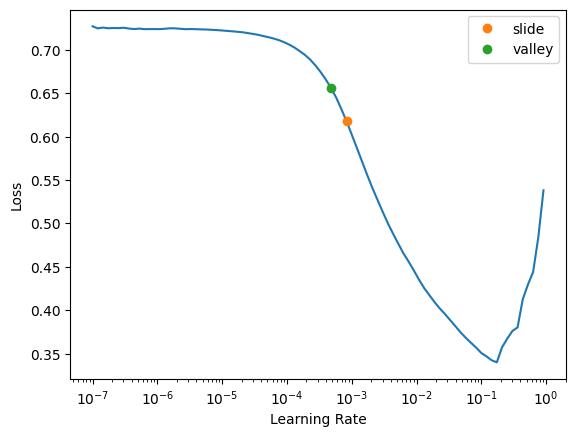

In [28]:
learner.lr_find(suggest_funcs=[slide, valley])

In [29]:
learner.fit_one_cycle(2,6.5e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.041105,0.039282,0.988386,04:51
1,0.033564,0.032370,0.990528,04:54


In [30]:
learner.save("question-classifier-stage-0")

Path('models/question-classifier-stage-0.pth')

# Stage - 1

In [ ]:
# learner.load("question-classifier-stage-0")

In [31]:
learner.unfreeze()

SuggestedLRs(slide=0.00015848931798245758, valley=2.0892961401841603e-05)

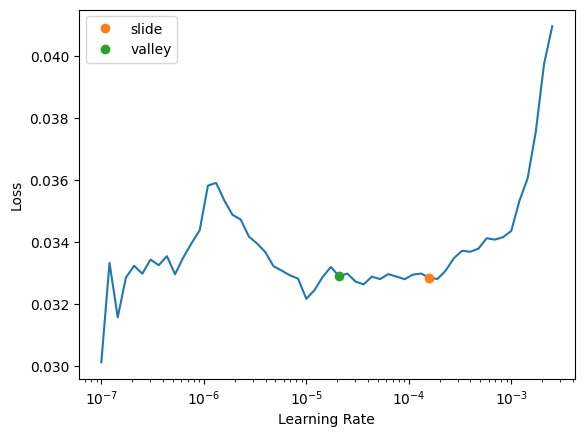

In [32]:
learner.lr_find(suggest_funcs=[slide, valley])

In [33]:
learner.fit_one_cycle(3,slice(5e-5, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.025565,0.025505,0.992631,06:48
1,0.021554,0.022004,0.993570,06:43
2,0.020212,0.021092,0.993616,06:48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [34]:
learner.save("question-classifier-stage-1")

Path('models/question-classifier-stage-1.pth')

In [35]:
learner.export(f"../../models/{model_name}/question-classifier-stage-1.pkl")